<a href="https://colab.research.google.com/github/PreamJ/LDA_TopicModelling_Legal/blob/main/topicmodeling_answer03_coherence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import gensim 
import gensim.corpora as corpora
from gensim import models
import pyLDAvis
from pprint import pprint
import pickle 
import os
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
RANDOM_STATE = 100

In [ ]:
data = pd.read_csv('dataset/DatasetLegal.csv')


In [ ]:
str_answer = data['answer'].astype(str)
str_answer = str_answer.map(lambda x: re.sub('[,.!?#/]', '', x))
str_question = data['question'].astype(str)
str_question = str_question.map(lambda x: re.sub('[,.!?*/]', '', x))

In [ ]:
sentense_token = []
for i in range(len(str_answer)):
  sentense_token.append(str_question[i])
  sentense_token.append(str_answer[i])

train_data = sentense_token[:12650]
test_data = sentense_token[12650:]

In [ ]:
word_token_answer = []
for sentense in train_data:
  word = word_tokenize(sentense, engine='newmm')
  word_token_answer.append(word)

In [ ]:
stopwords = list(thai_stopwords())
read_stopwords = pd.read_csv('dataset/add_stopwords.csv')
add_stopwords = read_stopwords['stopword'].values.tolist()
processed_answer = []
for sentense in word_token_answer:
  each_sentense = []
  for word in sentense:
    if(word not in stopwords + add_stopwords):
      each_sentense.append(word)
  processed_answer.append(each_sentense)

In [ ]:
id2word = corpora.Dictionary(processed_answer)
corpus = []
for text in processed_answer:
  vec = id2word.doc2bow(text)
  corpus.append(vec)

In [ ]:
# num_topics = range(4, 10)

# alpha_values = [0.01, 0.1, 0.5, 0.9]

# beta_values = [0.01, 0.1, 0.5, 0.9]

# # Initialize lists to store coherence scores and model parameters
# coherence_scores = []
# coherence_per_topic = []
# topic_params = []
# alpha_params = []
# beta_params = []

# # Loop over different combinations of topic, alpha, and beta parameter values
# for t in num_topics:
#     sub_coherence_per_topic = []
#     sub_coherence_score = []
#     for a in alpha_values:
#         for b in beta_values:
#             lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                                         id2word=id2word,
#                                                         num_topics=t,
#                                                         iterations=100,
#                                                         chunksize=200,
#                                                         passes=5,
#                                                         alpha=a,
#                                                         eta=b)
#             coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_answer, dictionary=id2word, coherence='c_v')
#             coherence_score = coherence_model_lda.get_coherence()
#             per_topic = coherence_model_lda.get_coherence_per_topic()
            
#             sub_coherence_per_topic.append(per_topic)
#             sub_coherence_score.append(coherence_score)
#             coherence_scores.append(coherence_score)
#             topic_params.append(t)
#             alpha_params.append(a)
#             beta_params.append(b)
#     coherence_per_topic.append(sub_coherence_per_topic[sub_coherence_score.index(max(sub_coherence_score))])
# max_score_index = coherence_scores.index(max(coherence_scores))
# optimal_topic_param = topic_params[max_score_index]

# print(f"Optimal number of topics: {optimal_topic_param}")
# print(f"Coherence score: {max(coherence_scores)}")

Optimal number of topics: 8
Optimal alpha value: 0.5
Optimal beta value: 0.5
Coherence score: 0.6711276188845379


In [44]:
num_topics = range(4,11)
coherence_scores = []
topic_params = []
coherence_per_topic = []
perplexity_scores = []


for t in num_topics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # preprocessed data
                                                id2word=id2word, # bow
                                                num_topics=t,
                                                iterations=100, # number of iterations performed within each pass
                                                # chunksize=2000, # I do not set chunksize cuz update_every=0 make chucksize irrelevant
                                                passes=10, # number of times the model goes through the entire training corpus
                                                alpha='auto', # how sparse of topic distribution
                                                eta='auto', # how sparse of word distribution
                                                random_state=RANDOM_STATE, 
                                                update_every=0, # frequency of parameter updates during training. 0 means model's parameters update after processing each individual document
                                                minimum_probability=0, 
                                                eval_every=1
                                                )
            
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_answer, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherence_per_topic.append(coherence_model_lda.get_coherence_per_topic())
    coherence_scores.append(coherence_score)
    topic_params.append(t)
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_scores.append(perplexity)

max_score_index = coherence_scores.index(max(coherence_scores))
optimal_topic_param = topic_params[max_score_index]

print(f"Optimal number of topics: {optimal_topic_param}")
print(f"Coherence score: {max(coherence_scores)}")

Optimal number of topics: 5
Coherence score: 0.569320675795124


Optimal number of topics: 5
Coherence score: 0.569320675795124

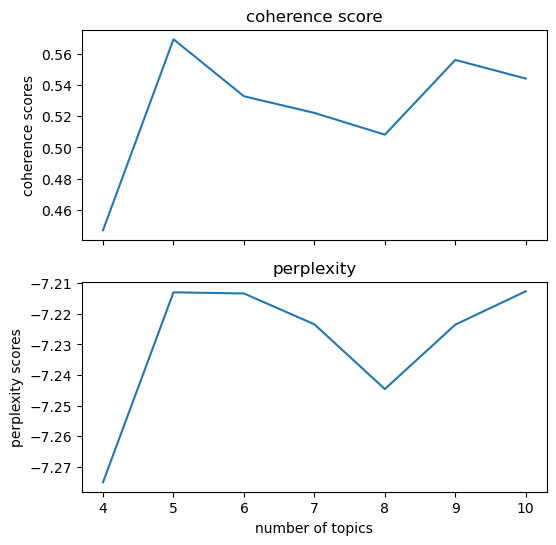

In [54]:
x = num_topics
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 6), sharex=True)
ax[0].plot(x, coherence_scores)
# ax[0].set_xlabel('number of topics')
ax[0].set_ylabel('coherence scores')
ax[0].set_title('coherence score')
ax[1].plot(x, perplexity_scores)
ax[1].set_xlabel('number of topics')
ax[1].set_ylabel('perplexity scores')
ax[1].set_title('perplexity')
plt.show()

In [56]:
num_topics = range(4,11)
coherence_scores = []
topic_params = []
coherence_per_topic = []
perplexity_scores = []


for t in num_topics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # preprocessed data
                                                id2word=id2word, # bow
                                                num_topics=t,
                                                iterations=100, # number of iterations performed within each pass
                                                # chunksize=2000, # I do not set chunksize cuz update_every=0 make chucksize irrelevant
                                                passes=1, # number of times the model goes through the entire training corpus
                                                alpha='auto', # how sparse of topic distribution
                                                eta='auto', # how sparse of word distribution
                                                random_state=RANDOM_STATE, 
                                                update_every=0, # frequency of parameter updates during training. 0 means model's parameters update after processing each individual document
                                                minimum_probability=0, 
                                                eval_every=1
                                                )
            
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_answer, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherence_per_topic.append(coherence_model_lda.get_coherence_per_topic())
    coherence_scores.append(coherence_score)
    topic_params.append(t)
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_scores.append(perplexity)

# max_score_index = coherence_scores.index(max(coherence_scores))
# optimal_topic_param = topic_params[max_score_index]

# print(f"Optimal number of topics: {optimal_topic_param}")
# print(f"Coherence score: {max(coherence_scores)}")

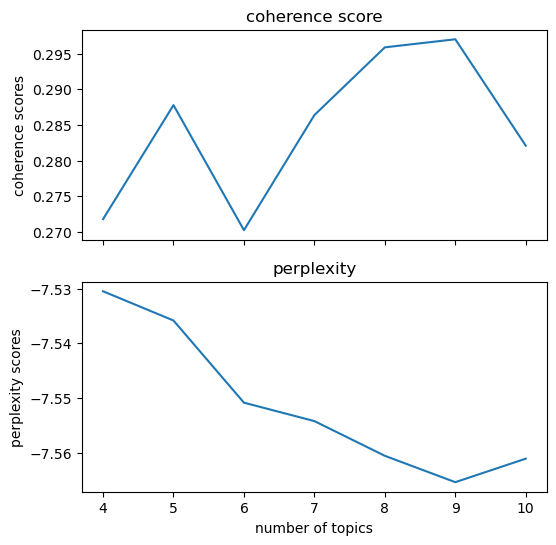

In [57]:
x = num_topics
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 6), sharex=True)
ax[0].plot(x, coherence_scores)
# ax[0].set_xlabel('number of topics')
ax[0].set_ylabel('coherence scores')
ax[0].set_title('coherence score')
ax[1].plot(x, perplexity_scores)
ax[1].set_xlabel('number of topics')
ax[1].set_ylabel('perplexity scores')
ax[1].set_title('perplexity')
plt.show()

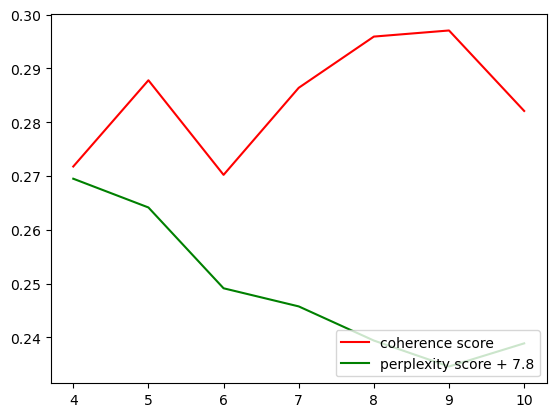

In [58]:
x = num_topics
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
mod_perplexity = [perp+7.8 for perp in perplexity_scores]


plt.plot(x, coherence_scores, color='r', label='coherence score')
plt.plot(x, mod_perplexity, color='g', label='perplexity score + 7.8')
plt.legend(loc='lower right')
plt.show()


Text(0, 0.5, 'coherence score')

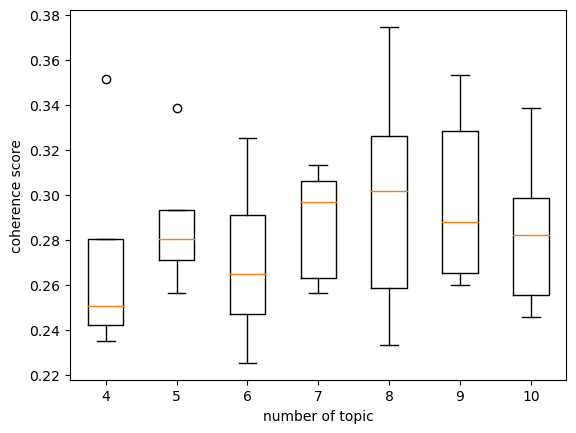

In [59]:
plt.boxplot(coherence_per_topic)
plt.xticks(range(1, 8), range(4, 11))
plt.xlabel('number of topic')
plt.ylabel('coherence score')

In [25]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=optimal_topic_param,
                                            iterations=100,
                                            chunksize=2000,
                                            passes=10,
                                            alpha='auto',
                                            eta='auto',
                                            random_state=RANDOM_STATE,
                                            update_every=0,
                                            minimum_probability=0,
                                            eval_every=1)
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_answer, dictionary=id2word, coherence='c_v')

In [27]:
coherence_per_topic_5 = coherence_model_lda.get_coherence_per_topic()

In [28]:
coherence_per_topic_5

[0.6660395756169644,
 0.4024109108587828,
 0.5456337843536775,
 0.5402265376863029,
 0.6922925704598925]

<BarContainer object of 5 artists>

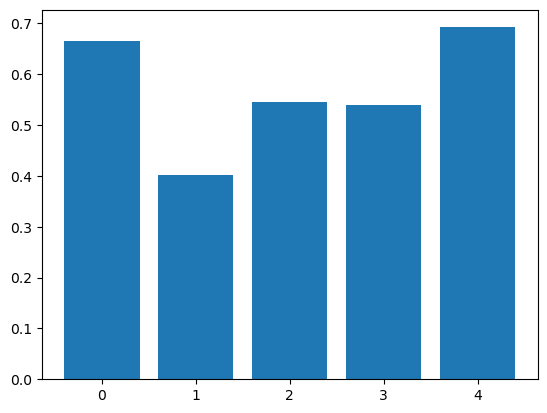

In [29]:
plt.bar(range(0,5), coherence_per_topic_5)

In [30]:
num_topics = range(4,11)
topic_params = []
num_topics_list = []
for t in num_topics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, # preprocessed data
                                                id2word=id2word, # bow
                                                num_topics=t,
                                                iterations=100, # number of iterations performed within each pass
                                                # chunksize=2000, # I do not set chunksize cuz update_every=0 make chucksize irrelevant
                                                passes=10, # number of times the model goes through the entire training corpus
                                                alpha='auto', # how sparse of topic distribution
                                                eta='auto', # how sparse of word distribution
                                                random_state=RANDOM_STATE, 
                                                update_every=0, # frequency of parameter updates during training. 0 means model's parameters update after processing each individual document
                                                minimum_probability=0, 
                                                eval_every=1
                                                )
            
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_scores.append(perplexity)
    num_topics_list.append(t)
